# Time Series Forecasting

> It's difficult to make predictions, especially about the future.

One of the most common problems in time series analysis is _forecasting_. Forecasting is simply prediction about the future. This is clearly relevant for climate scientists who want to predict future levels of $\text{CO}_2$, assuming that current trends persist.

<Axes: xlabel='date'>

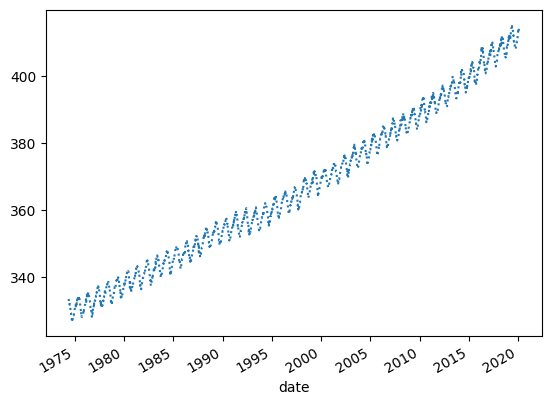

In [1]:
import pandas as pd

df_co2 = pd.read_csv("https://dlsun.github.io/pods/data/mauna_loa_co2_weekly.csv",
                     index_col="date", parse_dates=True)
df_co2 = df_co2[df_co2["ppm"] >= 0]

y_train = df_co2["ppm"]
y_train.plot.line(style=":")

## Modeling the Trend

First, we will model the overall trend. That is, we want to find a function $m$ of time such that the measurements $y_t$ can be modeled as

$$ y_t = m(t) + \text{noise}. $$

It is common to assume that $m$ is linear in $t$. That is,

$$ m(t) = b + c t, $$

for appropriate constants $b$ and $c$. Such a model can be fit by linear regression, by regressing the measurements $y_t$ on time $t$. Let's fit this model to data.

First, since the dates are currently datetimes, we convert them to decimals. We do not attempt to be exact here; we assume that there are 30 days in every month to convert each date into a day and divide by 365, ignoring leap years.

In [2]:
# Convert dates to a decimal year
date = df_co2.index
t = date.year + (30 * (date.month - 1) + date.day) / 365
t

Index([1974.3808219178081,             1974.4, 1974.4164383561645,
       1974.4356164383562,  1974.454794520548, 1974.4739726027397,
       1974.4931506849316, 1974.5123287671233,  1974.531506849315,
       1974.5506849315068,
       ...
        2019.964383561644, 2019.9835616438356,  2020.013698630137,
       2020.0328767123287, 2020.0520547945205, 2020.0712328767124,
       2020.0876712328768, 2020.1068493150685, 2020.1260273972603,
        2020.145205479452],
      dtype='float64', name='date', length=2369)

Now we fit the linear regression model, regressing the measurements on $y_t$ on $t$. Let's fit this model and plot the fitted trend on top of the data.

<Axes: xlabel='date'>

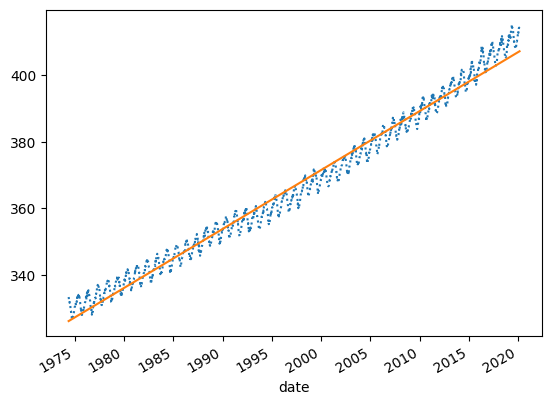

In [3]:
from sklearn.linear_model import LinearRegression

# Fit linear regression of y on t
model = LinearRegression()
model.fit(X=t.to_frame(), y=y_train)

# Store model predictions in a Series for easy plotting
y_train_ = pd.Series(
    model.predict(X=t.to_frame()),
    index=y_train.index
)

# Plot the data and the fitted trend
y_train.plot.line(style=":")
y_train_.plot.line()

It seems that the trend is more curved than it first appeared. Let's try a polynomial model.

$$ m(t) = b + c_1 t + c_2 t^2 $$

To fit a polynomial model, we simply create an $X$ matrix with two columns---the first storing values of $t$ and the second storing values of $t^2$.

$$ X = \begin{bmatrix} t_1 & t_1^2 \\ t_2 & t_2^2 \\ \vdots & \vdots \\ t_n & t_n^2 \end{bmatrix} $$

Scikit-learn provides `PolynomialFeatures` for carrying out transformations like this one.

In [4]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit_transform(t.to_frame())

array([[1.97438082e+03, 3.89817963e+06],
       [1.97440000e+03, 3.89825536e+06],
       [1.97441644e+03, 3.89832027e+06],
       ...,
       [2.02010685e+03, 4.08083168e+06],
       [2.02012603e+03, 4.08090917e+06],
       [2.02014521e+03, 4.08098665e+06]])

Now let's put it all together.

<Axes: xlabel='date'>

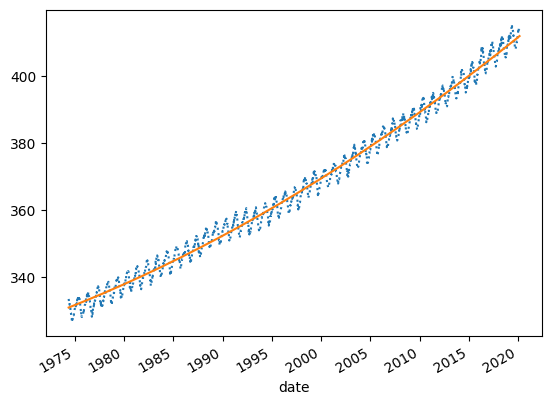

In [5]:
from sklearn.pipeline import make_pipeline

# Fit linear regression of y on t and t^2
pipeline = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LinearRegression()
)
pipeline.fit(X=t.to_frame(), y=y_train)

# Store model predictions in a Series for easy plotting
y_train_ = pd.Series(
    pipeline.predict(X=t.to_frame()),
    index=y_train.index
)

# Plot the data and the fitted trend
y_train.plot.line(style=":")
y_train_.plot.line()

The polynomial model seems to capture the trend much better. Now, if we want to make a forecast of the atmospheric $\text{CO}_2$ levels in 2030, we simply plug 2030 into the model that we just fit.

In [6]:
pipeline.predict([[2030]])

/Users/ishaansathaye/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


array([436.62487429])

However, be wary of predicting far into the future! Just because a trend has persisted in the past doesn't necessarily mean it will continue in the future.

## Modeling the Seasonality

What about the seasonal fluctuations in the $\text{CO}_2$ levels that are caused by plant photosynthesis? If we want to make predictions for a particular month in a year, then we will also want to take the seasonality into account.

That is, we need a model of the form

$$ y_t = m(t) + s(t) + \text{noise}, $$

where $m(t)$ is the trend as before and $s(t)$ is the seasonal component. If $f$ is the frequency of the seasonal component, it is typical to model $s$ as the sum of a sine and a cosine with that frequency.

$$ s(t) = a_1 \sin(2\pi f t) + a_2 \cos(2\pi f t) $$

In our case, the seasonality has a frequency of $f = 1 \text{ cycle / year}$. To fit a model like the one above, we need to transform $t$ into:
- $t$ and $t^2$ for the trend, as above
- $\sin(2\pi\cdot 1 t)$ and $\cos(2\pi\cdot 1 t)$ for the seasonal component

and then stack them all into one feature matrix to be passed to linear regression. The sine and cosine transformation can be done in scikit-learn by creating custom `FunctionTransformer`s. Then, the columns can be stacked by creating a `FeatureUnion` using `make_union`.

<Axes: xlabel='date'>

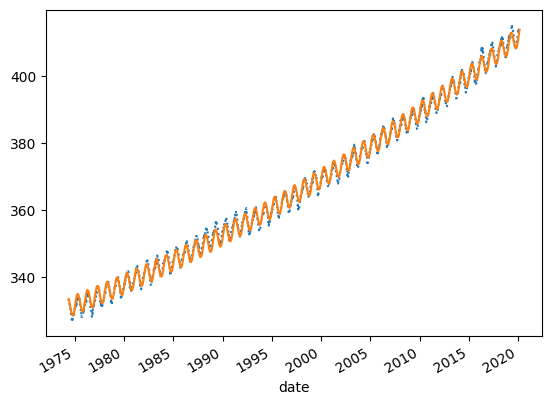

In [7]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_union

# Fit linear regression on t, t^2, sin(2 * pi * t), cos(2 * pi * t)
pipeline = make_pipeline(
    make_union(
        PolynomialFeatures(degree=2, include_bias=False),
        FunctionTransformer(lambda t: np.sin(2 * np.pi * 1 * t)),
        FunctionTransformer(lambda t: np.cos(2 * np.pi * 1 * t))
    ),
    LinearRegression()
)
pipeline.fit(X=t.to_frame(), y=y_train)

# Store model predictions in a Series for easy plotting
y_train_ = pd.Series(
    pipeline.predict(t.to_frame()),
    index=y_train.index
)

# Plot the data and the fitted trend
y_train.plot.line(style=":")
y_train_.plot.line()

Now, let's make a prediction for April and October, 2030.

In [8]:
pipeline.predict(
    np.array([
        [2030.3],
        [2030.8]
    ])
)

/Users/ishaansathaye/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


array([440.49427546, 435.99658236])

Despite the increasing trend, the $\text{CO}_2$ is predicted to be lower in October than in April because of the seasonality.